In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip -q install -U transformers datasets accelerate evaluate
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.0 MB/s eta 0:00:00


In [3]:
path = "/content/drive/MyDrive/AI_Human.csv"
df = pd.read_csv(path)

print(df.shape)
print(df.columns)
print(df.head())


(487235, 2)
Index(['text', 'generated'], dtype='object')
                                                text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0


In [4]:
df = df[['text','generated']].copy()
df = df.dropna(subset=['text','generated'])
df['text'] = df['text'].astype(str)
df['generated'] = pd.to_numeric(df['generated'], errors='coerce')
df = df.dropna(subset=['generated'])
df['generated'] = df['generated'].astype(int)

df = df.drop_duplicates(subset=['text'])
df = df[df['text'].str.len() >= 20].reset_index(drop=True)

print(df.shape)
print(df['generated'].value_counts())


(487228, 2)
generated
0    305797
1    181431
Name: count, dtype: int64


In [15]:
n_total = 10000
n_each = n_total // 2

df0 = df[df['generated'] == 0].sample(n=n_each, random_state=42)
df1 = df[df['generated'] == 1].sample(n=n_each, random_state=42)

df10k = pd.concat([df0, df1]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df10k.shape)
print(df10k['generated'].value_counts())


(10000, 2)
generated
1    5000
0    5000
Name: count, dtype: int64


In [16]:
train_df, temp_df = train_test_split(
    df10k,
    test_size=0.3,
    random_state=42,
    stratify=df10k['generated']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=2/3,
    random_state=42,
    stratify=temp_df['generated']
)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)


(7000, 2)
(1000, 2)
(2000, 2)


In [17]:
train_hf = Dataset.from_pandas(train_df[['text','generated']].rename(columns={'generated':'labels'}), preserve_index=False)
val_hf = Dataset.from_pandas(val_df[['text','generated']].rename(columns={'generated':'labels'}), preserve_index=False)
test_hf = Dataset.from_pandas(test_df[['text','generated']].rename(columns={'generated':'labels'}), preserve_index=False)

train_hf, val_hf, test_hf


(Dataset({
     features: ['text', 'labels'],
     num_rows: 7000
 }),
 Dataset({
     features: ['text', 'labels'],
     num_rows: 1000
 }),
 Dataset({
     features: ['text', 'labels'],
     num_rows: 2000
 }))

In [18]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_len = 128

def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_len)

train_tok = train_hf.map(tok, batched=True)
val_tok = val_hf.map(tok, batched=True)
test_tok = test_hf.map(tok, batched=True)

cols = ["input_ids", "attention_mask", "labels"]

train_tok = train_tok.remove_columns([c for c in train_tok.column_names if c not in cols])
val_tok = val_tok.remove_columns([c for c in val_tok.column_names if c not in cols])
test_tok = test_tok.remove_columns([c for c in test_tok.column_names if c not in cols])

train_tok.set_format("torch")
val_tok.set_format("torch")
test_tok.set_format("torch")


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [19]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}


In [20]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

args = TrainingArguments(
    output_dir="/content/bert_ai_detect",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3758181932.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
trainer.train()


Step,Training Loss
500,0.164200


TrainOutput(global_step=876, training_loss=0.10658637573729911, metrics={'train_runtime': 341.1891, 'train_samples_per_second': 41.033, 'train_steps_per_second': 2.567, 'total_flos': 920888693760000.0, 'train_loss': 0.10658637573729911, 'epoch': 2.0})

In [23]:
from sklearn.metrics import classification_report

test_out = trainer.predict(test_tok)

preds = np.argmax(test_out.predictions, axis=1)
labels = test_out.label_ids

acc = accuracy_score(labels, preds)
print("Accuracy:", acc)

print("\nClassification Report:\n")
print(classification_report(labels, preds, digits=2))



Accuracy: 0.967

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1000
           1       0.95      0.99      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



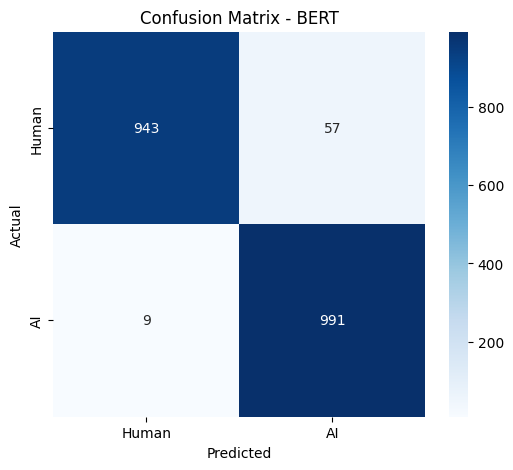

In [25]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Human", "AI"],
    yticklabels=["Human", "AI"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BERT")
plt.show()


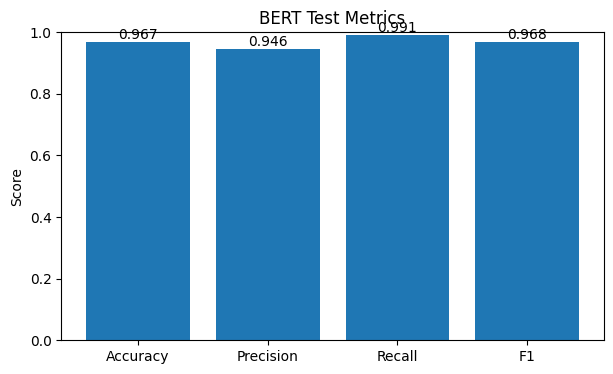

In [26]:
m = test_out.metrics

names = ["Accuracy", "Precision", "Recall", "F1"]
values = [m["test_accuracy"], m["test_precision"], m["test_recall"], m["test_f1"]]

plt.figure(figsize=(7,4))
bars = plt.bar(names, values)
plt.ylim(0,1)

for b in bars:
    y = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, y + 0.01, f"{y:.3f}", ha="center")

plt.title("BERT Test Metrics")
plt.ylabel("Score")
plt.show()
